In [1]:
%%time
import torch
import tqdm
from PIL import Image
import numpy as np
import os
from gs_lib import getFinalData

# The only two files that are needed for rendering.
dataset = "/home/suresh/2024/gs/datasets/models/truck"
iteration = "30000"
max_sh_degree = 3
json_file = f"{dataset}/cameras.json"
ply_file = f"{dataset}/point_cloud/iteration_{iteration}/point_cloud.ply"
view = 52
output_scale_down = 2  # How much to scale down from the original image
tile_size = 16  # Block size for tile-based splatting/rendering
bg = 0  # use 1 for white, 0 for black

# Check for the available paraller device
device = "mps" if getattr(torch, 'has_mps', False) else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device running on = {device}")
# device = "cpu"

final_w, final_h, total_blocks, final_2d_gaussians_reduced, \
    final_covariance_reduced, depth_reduced, opacities_reduced, \
    colors_precomp_reduced, bg_color, bounding_rectange = getFinalData(ply_file, json_file, max_sh_degree, view, output_scale_down, tile_size, bg)

Device running on = cuda
CPU times: user 14.1 s, sys: 1.24 s, total: 15.3 s
Wall time: 1.94 s


In [2]:
# Lets sort all the datastructures according to the depth. 
# The ordering is from closest-gaussian to the farest-gaussian
sorted_depths, index = torch.sort(depth_reduced)
sorted_xy = final_2d_gaussians_reduced[index]
sorted_final_covariance = final_covariance_reduced[index] # P 2 2
sorted_conic = sorted_final_covariance.inverse() # inverse of variance
sorted_opacity = opacities_reduced[index]
sorted_color = colors_precomp_reduced[index]

rect_min, rect_max = bounding_rectange
rect_area = (rect_max[:, 0] - rect_min[:, 0]) * (rect_max[:, 1] - rect_min[:, 1])
sorted_rect_min = rect_min[index].round()
sorted_rect_max = rect_max[index].round()
sorted_rect_area = rect_area[index]

In [3]:
# Send all variables to the "device"
sorted_depths = sorted_depths.to(device)
sorted_xy = sorted_xy.to(device)
sorted_final_covariance = sorted_final_covariance.to(device)
sorted_conic = sorted_conic.to(device)
sorted_opacity = sorted_opacity.to(device)
sorted_color = sorted_color.to(device)
sorted_rect_min = sorted_rect_min.to(device)
sorted_rect_max = sorted_rect_max.to(device)
sorted_rect_area = sorted_rect_area.to(device)
# # print(f"Sent all variables to : \n\t{sorted_xy.device} \
# \n\t{sorted_depths.device}\n\t{sorted_final_covariance.device} \
# \n\t{sorted_conic.device}\n\t{sorted_opacity.device} \
# \n\t{sorted_color.device}")

In [4]:
%%time
# Rendering one gaussian at a time
# Heavily influenced from https://github.com/arnaudstiegler/torch-gaussian-splatting-rasterizer
screen = torch.zeros((int(final_w), int(final_h), 3), device=device).float()
opacity_buffer = torch.ones((int(final_w), int(final_h)), device=device).float()

# Helper variables
it_cont = 0
it = 0
# Set maximum density to prevent overflow issues
MAX_GAUSSIAN_DENSITY = 0.99
# Minimum alpha before stopping to blend new gaussians (they will not be visible in any case)
MIN_ALPHA = 1 / 255


for i in tqdm.tqdm(range(sorted_depths.shape[0]), bar_format='{desc:<5.5}{percentage:3.0f}%|{bar:10}{r_bar}'):
    
    # Check to see if the areas of rectangle or covariance is zero.
    # Its a non-existing gaussian
    # skip calculations for it.
    if (sorted_rect_area[i] == 0) or (torch.any(sorted_conic[i]) == 0):
        it_cont += 1
        continue

    # ----------------------------------
    # render each gaussian
    gaussian_index = i
    sigma_x, sigma_y, sigma_x_y = sorted_conic[i][0, 0], sorted_conic[i][1, 1], sorted_conic[i][0, 1]
    x_grid = torch.arange(sorted_rect_min[i, 0], sorted_rect_max[i, 0])
    y_grid = torch.arange(sorted_rect_min[i, 1], sorted_rect_max[i, 1])
    mesh_x, mesh_y = torch.meshgrid(x_grid, y_grid, indexing="ij")
    mesh = torch.stack([mesh_x, mesh_y], dim=-1).view(-1, 2).to(device)

    # We compute the transmittance of the gaussian at each pixel covered which determines how much the new
    # gaussian contributes to the color of the resulting pixel
    dist_to_mean = sorted_xy[gaussian_index] - mesh    
    gaussian_density = (-0.5 * (sigma_x * (dist_to_mean[:, 0] ** 2) + sigma_y * (dist_to_mean[:, 1] ** 2)) - sigma_x_y * dist_to_mean[:, 0] * dist_to_mean[:, 1])

    alpha = torch.min(
        sorted_opacity[gaussian_index] * torch.exp(gaussian_density),
        torch.tensor([MAX_GAUSSIAN_DENSITY], device=sorted_xy.device),
    ).float()

    # For numerical stability
    valid = (alpha > MIN_ALPHA) & (gaussian_density <= 0)
    valid_mesh = mesh[valid, :].int()

    # Update the screen pixels with the alpha blending values for each of the pixel
    screen[valid_mesh[:, 0], valid_mesh[:, 1], :] += (
        alpha[valid, None] * sorted_color[gaussian_index] * opacity_buffer[valid_mesh[:, 0], valid_mesh[:, 1], None]
    )

    # Update the opacity buffer to track how much transmittance is left before each pixel is "saturated"
    # i.e cannot transmit color from "deeper" gaussians
    opacity_buffer[valid_mesh[:, 0], valid_mesh[:, 1]] = opacity_buffer[valid_mesh[:, 0], valid_mesh[:, 1]] * (1 - alpha[valid])
    # ------------------------------------
    
    # if it == 10:
    #     break
    it += 1
    if it % 1000 == 0:
        img = Image.fromarray((screen[:, :, :3].transpose(1, 0).cpu().numpy() * 255.0).astype(np.uint8))
        img.save(os.path.join("/home/suresh/2024/gs/notebooks/out", f"image_iter_{str(it).zfill(7)}.png",))
    
img = Image.fromarray((screen[:, :, :3].transpose(1, 0).cpu().numpy() * 255.0).astype(np.uint8))
img.save(os.path.join("/home/suresh/2024/gs/notebooks/out", f"final.png",))

print(f"Done in {it_cont}(gaussians skipped) + {it}(gaussians splatted) = {it_cont+it} steps!")

     100%|██████████| 1621315/1621315 [04:16<00:00, 6317.50it/s] 

Done in 1020135 + 601180 = 1621315 steps!
CPU times: user 7min 10s, sys: 505 ms, total: 7min 11s
Wall time: 4min 16s


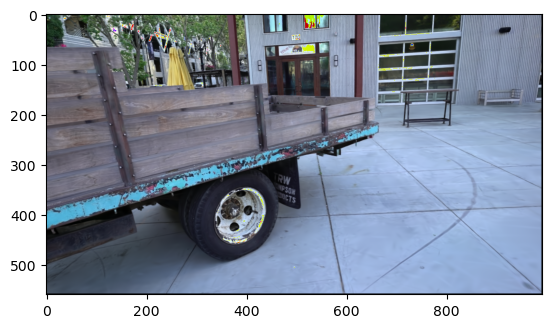

In [5]:
import matplotlib.pyplot as plt
img = Image.open("/home/suresh/2024/gs/notebooks/out/final.png")
plt.imshow(img)
plt.show()

## Note
The above for loop cannot be parallizable. It has a loop-carried dependence. 